# State Farm (with data augmentation)

## Steps:

1. load train and validation data
2. load VGG model
3. train
4. test

In [28]:
%matplotlib inline

## 1. Load data

In [1]:
floydhub = False
sample = False

In [2]:
if floydhub:
    data_path = "/input/"
    bottleneck_path = "/output/bottlenecks/"
    results_path = "/output/results/"
else:
    data_path = "./data/"
    if sample:
        data_path += "sample/"
    bottleneck_path = "./bottlenecks/"
    results_path = "./results/"
%mkdir $bottleneck_path
%mkdir $results_path

mkdir: cannot create directory ‘./bottlenecks/’: File exists
mkdir: cannot create directory ‘./results/’: File exists


In [3]:
batch_size = 64

In [41]:
from utils import get_batches
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=1, width_shift_range=0.08, height_shift_range=0.08, zoom_range=0.0, channel_shift_range=1, featurewise_center=False, samplewise_center=False)

train_gen = get_batches(data_path + "train", gen=gen, shuffle=True, batch_size=batch_size,
                target_size=(224,224))
valid_gen = get_batches(data_path + "valid", gen=ImageDataGenerator(), shuffle=False, batch_size=batch_size*2,
                target_size=(224,224))

Found 19658 images belonging to 10 classes.
Found 2766 images belonging to 10 classes.


(64, 3, 224, 224)


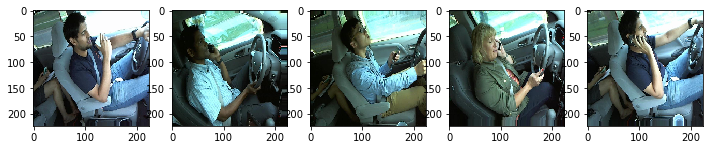

In [42]:
from utils import plots
print(train_gen.next()[0].shape)
plots(train_gen.next()[0][:5])

## 2. Load VGG

In [44]:
from vgg16 import Vgg16

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization

vgg = Vgg16()

while not isinstance(vgg.model.layers[-1], Flatten):
    vgg.model.pop()

for layer in vgg.model.layers:
    layer.trainable = False

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [45]:
vgg.model.add(BatchNormalization())
vgg.model.add(Dense(4096, activation='relu'))
vgg.model.add(BatchNormalization())
vgg.model.add(Dropout(0.2))
vgg.model.add(Dense(4096, activation='relu'))
vgg.model.add(BatchNormalization())
vgg.model.add(Dropout(0.2))
vgg.model.add(Dense(10, activation="softmax"))

vgg.compile()

In [7]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

## 4. Train classification network

In [46]:
from keras.callbacks import ModelCheckpoint, LambdaCallback
#cb = [ModelCheckpoint("vgg16-aug-{epoch:02d}-{val_loss:.3f}.hdf5", verbose=1)]
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
plot_loss_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print(epoch))
cb = [ModelCheckpoint("vgg16-aug-{epoch:02d}-{val_loss:.3f}.hdf5", verbose=1)]

In [47]:
vgg.model.optimizer.lr = 0.01
vgg.model.fit_generator(train_gen, samples_per_epoch=train_gen.nb_sample, nb_epoch=5, validation_data=valid_gen, nb_val_samples=valid_gen.nb_sample, verbose=2, callbacks=cb)

Epoch 1/5
Epoch 00000: saving model to vgg16-aug-00-3.912.hdf5


TypeError: get_value() can only be called on a variable. If you have an expression instead, use eval().

In [48]:
# no CBs
vgg.model.optimizer.lr = 0.01
vgg.model.fit_generator(train_gen, samples_per_epoch=train_gen.nb_sample, nb_epoch=5, validation_data=valid_gen, nb_val_samples=valid_gen.nb_sample, verbose=2)

Epoch 1/5
612s - loss: 3.1016 - acc: 0.7957 - val_loss: 5.2829 - val_acc: 0.6508
Epoch 2/5
611s - loss: 2.0966 - acc: 0.8628 - val_loss: 7.0552 - val_acc: 0.5539
Epoch 3/5
613s - loss: 1.7258 - acc: 0.8865 - val_loss: 3.9182 - val_acc: 0.7484
Epoch 4/5
614s - loss: 1.5949 - acc: 0.8952 - val_loss: 3.8502 - val_acc: 0.7552
Epoch 5/5
615s - loss: 1.6944 - acc: 0.8907 - val_loss: 6.2472 - val_acc: 0.6063


In [51]:
vgg.model.optimizer.lr = 0.001
vgg.model.fit_generator(train_gen, samples_per_epoch=train_gen.nb_sample, nb_epoch=5, validation_data=valid_gen, nb_val_samples=valid_gen.nb_sample, verbose=2)

Epoch 1/5
616s - loss: 1.6235 - acc: 0.8954 - val_loss: 3.3141 - val_acc: 0.7885
Epoch 2/5
617s - loss: 1.4999 - acc: 0.9035 - val_loss: 3.2657 - val_acc: 0.7918
Epoch 3/5
616s - loss: 1.4792 - acc: 0.9054 - val_loss: 4.2520 - val_acc: 0.7281
Epoch 4/5


KeyboardInterrupt: 

In [ ]:
vgg.model.optimizer.lr = 0.0001
vgg.model.fit_generator(train_gen, samples_per_epoch=train_gen.nb_sample, nb_epoch=7, validation_data=valid_gen, nb_val_samples=valid_gen.nb_sample, verbose=2)

In [ ]:
#!sudo shutdown -h now

In [50]:
vgg.model.save_weights("weights.hdf5")